Header information:
SIMPLE  =                    T / file does conform to FITS standard             BITPIX  =                    8 / number of bits per data pixel                  NAXIS   =                    2 / number of data axes                            NAXIS1  =                 3600 / length of data axis 1                          NAXIS2  =                  200 / length of data axis 2                          EXTEND  =                    T / FITS dataset may contain extensions            COMMENT   FITS (Flexible Image Transport System) format defined in Astronomy andCOMMENT   Astrophysics Supplement Series v44/p363, v44/p371, v73/p359, v73/p365.COMMENT   Contact the NASA Science Office of Standards and Technology for the   COMMENT   FITS Definition document #100 and other FITS information.             DATE    = '2025-01-08'         / Time of observation                            CONTENT = '2025/01/08  Radio flux density, e-CALLISTO (ETH)' / Title of image   ORIGIN  = 'Astro   '

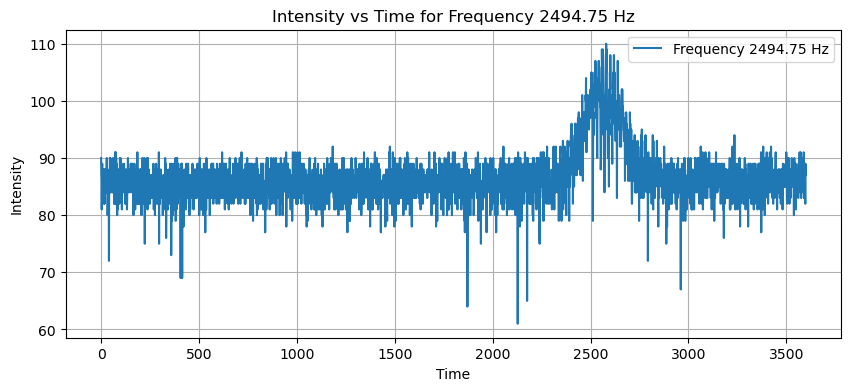

In [35]:
# Import necessary libraries
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# Load the .fits file
file_path = "sat_interest_25/ETH_20250108_004500_01.fit"  # Replace with your actual file path
hdul = fits.open(file_path)

# Display the header information (optional)
print("Header information:")
print(hdul[0].header)

# Access the data (assuming it's a 2D array with shape [frequency, time])
data = hdul[0].data

# Extract frequency and time from header (if provided)
# You may need to adjust these keys based on your file
freq_axis = np.arange(data.shape[0])  # Dummy frequency axis if not provided
freq_axis = hdul[1].data[0][1]
time_axis = np.arange(data.shape[1])  # Dummy time axis if not provided

# Close the file
hdul.close()

# Choose a specific frequency index (modify as needed)
frequency_index = 79  # Example: choose the 50th frequency; adjust as per your data
chosen_frequency = freq_axis[frequency_index]  # Get the actual frequency value if freq_axis is defined

# Plot the intensity of the chosen frequency over time
plt.figure(figsize=(10, 4))
plt.plot(time_axis, data[frequency_index, :], label=f'Frequency {chosen_frequency} Hz')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Intensity vs Time for Frequency {chosen_frequency} Hz')
plt.legend()
plt.grid(True)
plt.show()


Fitted Gaussian Parameters:
Amplitude: 15.290598489370963
Center (x0): 2562.9962711289654
Width (sigma): 99.64598073583444
Baseline (y0): 85.57549559519026


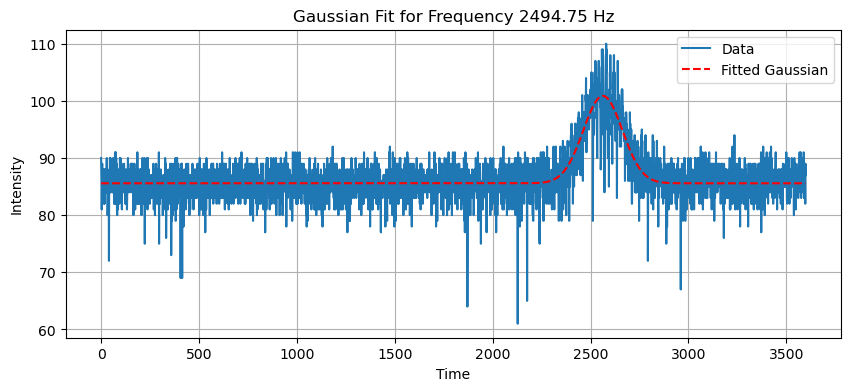

Peak Time Period: 2363.70 to 2762.29


In [40]:
from scipy.optimize import curve_fit

intensity = data[frequency_index, :]

# Define a Gaussian function
def gaussian(x, a, x0, sigma, y0):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + y0

# Estimate initial parameters for the Gaussian
a_initial = np.max(intensity) - np.min(intensity)  # Amplitude guess
x0_initial = time_axis[np.argmax(intensity)]  # Peak position guess
sigma_initial = np.std(time_axis) / 10  # Width guess
y0_initial = np.min(intensity)  # Baseline guess
initial_guess = [a_initial, x0_initial, sigma_initial, y0_initial]

# Fit the Gaussian
params, covariance = curve_fit(gaussian, time_axis, intensity, p0=initial_guess)

# Extract fitted parameters
a_fit, x0_fit, sigma_fit, y0_fit = params
print(f"Fitted Gaussian Parameters:\n"
      f"Amplitude: {a_fit}\n"
      f"Center (x0): {x0_fit}\n"
      f"Width (sigma): {sigma_fit}\n"
      f"Baseline (y0): {y0_fit}")

# Plot the fitted Gaussian over the data
plt.figure(figsize=(10, 4))
plt.plot(time_axis, intensity, label='Data')
plt.plot(time_axis, gaussian(time_axis, *params), label='Fitted Gaussian', linestyle='--', color='red')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.title(f'Gaussian Fit for Frequency {chosen_frequency} Hz')
plt.legend()
plt.grid(True)
plt.show()

# Return the starting values of the Gaussian
start_time = x0_fit - 2 * sigma_fit
end_time = x0_fit + 2 * sigma_fit
print(f"Peak Time Period: {start_time:.2f} to {end_time:.2f}")
dT = 2*np.sqrt(2*np.log(2))*sigma_fit

In [45]:
import sympy as sp

# Define the symbols
r= sp.symbols('r')

# Constants (with units converted where necessary)
R = 6371 * 1000  # Radius of the Earth in meters
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
M = 5.972e24  # Mass of the Earth in kg
a = 14 * 0.01745329 # Beam angle in radians
t = dT

# Define the equation
equation = r**3 + R*r**2 - (G * M * dT**2) / a**2

# Solve the equation for r
solutions = sp.solve(equation, r)

# Display the solutions
for i, sol in enumerate(solutions):
    print(f"Solution {i + 1}: {sol}")


Solution 1: 5552339.10958999
Solution 2: -5961669.554795 - 5537230.18977095*I
Solution 3: -5961669.554795 + 5537230.18977095*I


In [ ]:
from skyfield.api import Topos, load
from datetime import datetime, timedelta

# Load satellite TLE data
satellites = load.tle_file('https://www.celestrak.com/NORAD/elements/active.txt')
ts = load.timescale()

# Set observer location (example: New York City)
location = Topos(latitude_degrees=40.7128, longitude_degrees=-74.0060)

# Define time range for prediction
start_time = ts.utc(datetime.utcnow())
end_time = ts.utc(datetime.utcnow() + timedelta(days=1))

# Find satellite passes for each satellite
for satellite in satellites:
    t, events = satellite.find_events(location, start_time, end_time, altitude_degrees=30.0)
    for ti, event in zip(t, events):
        event_name = ('rise', 'culminate', 'set')[event]
        print(f"{satellite.name} {event_name} at {ti.utc_strftime('%Y-%m-%d %H:%M:%S')} UTC")
